## Facial emotion recognition
- This is an ipynb file created in Kaggle environment.
- Xception + fine-tuning

#### Dataset
- MMA FACIAL EXPRESSION, https://www.kaggle.com/mahmoudima/mma-facial-expression

## 0. Import Packages

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import os

2021-09-29 03:48:23.451732: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## 1. Make dataset

In [9]:
batch_size = 128
img_height = 180
img_width = 180
preprocessed_training = []
preprocessed_validation = []

In [10]:
train_datagen = ImageDataGenerator(
        preprocessing_function = preprocess_input,  ### change
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)    
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)    

In [11]:
train_generator = train_datagen.flow_from_directory("/kaggle/input/mma-facial-expression/MMAFEDB/train",
                                                      target_size=(img_width, img_height),
                                                      batch_size=batch_size,
                                                      class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory("/kaggle/input/mma-facial-expression/MMAFEDB/valid",
                                                      target_size=(img_width, img_height),
                                                      batch_size=batch_size,
                                                      class_mode='categorical')
test_generator = test_datagen.flow_from_directory("/kaggle/input/mma-facial-expression/MMAFEDB/test",
                                                      target_size=(img_width, img_height),
                                                      batch_size=batch_size,
                                                      class_mode='categorical')

Found 92968 images belonging to 7 classes.
Found 17356 images belonging to 7 classes.
Found 17356 images belonging to 7 classes.


In [12]:
# base model : xception -> fine tuning
model = tf.keras.applications.Xception(weights='imagenet',include_top=False, input_shape=(img_width, img_height,3))
model.summary()

2021-09-29 03:50:28.499306: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-29 03:50:28.502658: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-29 03:50:28.557931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-29 03:50:28.558677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-29 03:50:28.558751: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-29 03:50:28.585928: I tensorflow/stream_executor/platform/def

83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 89, 89, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 89, 89, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 89, 89, 32)   0           block1_conv1_bn[0][0]            
__________________________

In [13]:
# Change last layer to fit out needs: 7 classes
x = model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(model.input, predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 89, 89, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 89, 89, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 89, 89, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# params
nb_epoch = 10
num_train = 92968
num_val = 17356

In [17]:
%%time
hist = model.fit(
    train_generator,
    epochs = nb_epoch,
    steps_per_epoch = num_train//batch_size,
    validation_data = validation_generator,
    validation_steps = num_val//batch_size)

2021-09-29 03:56:25.482540: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-29 03:56:25.486994: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000170000 Hz


Epoch 1/10


2021-09-29 03:56:29.406058: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-29 03:56:30.230085: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-29 03:56:31.039802: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


726/726 [==============================] - 1404s 2s/step - loss: 1.0890 - accuracy: 0.6136 - val_loss: 1.2906 - val_accuracy: 0.5570
Epoch 2/10
726/726 [==============================] - 1048s 1s/step - loss: 0.8501 - accuracy: 0.6994 - val_loss: 1.2272 - val_accuracy: 0.5751
Epoch 3/10
726/726 [==============================] - 1048s 1s/step - loss: 0.7962 - accuracy: 0.7190 - val_loss: 1.1474 - val_accuracy: 0.5971
Epoch 4/10
726/726 [==============================] - 1052s 1s/step - loss: 0.7518 - accuracy: 0.7327 - val_loss: 1.1741 - val_accuracy: 0.5894
Epoch 5/10
726/726 [==============================] - 1046s 1s/step - loss: 0.7117 - accuracy: 0.7469 - val_loss: 1.1471 - val_accuracy: 0.6009
Epoch 6/10
726/726 [==============================] - 1041s 1s/step - loss: 0.6774 - accuracy: 0.7586 - val_loss: 1.2572 - val_accuracy: 0.5878
Epoch 7/10
726/726 [==============================] - 1047s 1s/step - loss: 0.6431 - accuracy: 0.7696 - val_loss: 1.4845 - val_accuracy: 0.5512
Epo

In [26]:
# Save model
model.save("/kaggle/working/xception.h5")
# model.save_weigths("/kaggle/working/xception_weights.h5")

xception_json = model.to_json()

with open("/kaggle/working/xception.json", "w") as json_file:
    json_file.write(xception_json)

In [27]:
# Load fitted model


model = load_model('/kaggle/working/xception.h5')

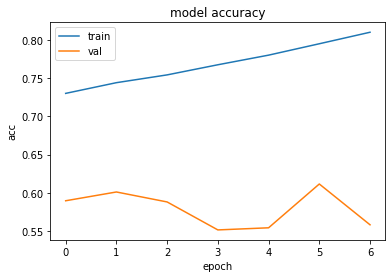

In [20]:
plt.plot(hist.history['accuracy'][3:50])
plt.plot(hist.history['val_accuracy'][3:50])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
print("-- Evaluate --")
scores = model.evaluate(test_generator, steps=num_val//batch_size)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
135/135 [==============================] - 91s 674ms/step - loss: 1.2637 - accuracy: 0.5976
accuracy: 59.76%


In [22]:
print("-- Predict --")
pred = model.predict(test_generator, steps=num_val//batch_size)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(pred)

-- Predict --
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
[[0.002 0.044 0.010 ... 0.289 0.009 0.618]
 [0.003 0.000 0.007 ... 0.851 0.010 0.006]
 [0.024 0.001 0.083 ... 0.000 0.000 0.892]
 ...
 [0.998 0.002 0.000 ... 0.000 0.000 0.000]
 [0.004 0.008 0.002 ... 0.034 0.025 0.022]
 [0.028 0.114 0.002 ... 0.790 0.019 0.045]]


In [23]:
prediction = np.argmax(pred, axis=1)

In [24]:
test_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [25]:
img, label = test_generator.next()
print(np.shape(img), np.shape(label))

(128, 180, 180, 3) (128, 7)


In [ ]:
# for i in range(5):
#     print("answer :", np.argmax(label[i,:]), "pred :", prediction[i])
#     plt.imshow(img[i,:,:,:])
#     plt.show()

### Reference
[1] https://www.kaggle.com/nicolasceccarello/xception